In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,callbacks,optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dense,concatenate,Input,Dropout,BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import ConfusionMatrixDisplay
from glob import glob
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.metrics import f1_score

In [2]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# To check GPU status
!nvidia-smi

Num GPUs Available:  1


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Sun Nov 24 23:37:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             28W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
train_dir = r"/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/training"
test_dir = r"/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/testing"

/kaggle/input/diabetic-retinopathy-level-detection/inception-diabetic.h5
/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/training/2/6dcde47060f9.png
/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/training/2/be68322c7223.png
/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/training/2/a688f20f8895.png
/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/training/2/d4be0403e6ab.png
/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/training/2/388f12e8df0b.png
/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/training/2/d83c3efade75.png
/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preprocessed dataset/training/2/1e4650743fa2.png
/kaggle/input/diabetic-retinopathy-level-detection/preprocessed dataset/preproce

In [4]:
# Image parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224  # ResNet50 and Xception input size
BATCH_SIZE = 64

In [5]:
# Image enhancement function using histogram equalization and intensity normalization
def enhance_image(img):
    # Histogram Equalization
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_enhanced = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Intensity Normalization
    img_normalized = (img_enhanced - img_enhanced.min()) / (img_enhanced.max() - img_enhanced.min())

    return img_normalized

In [6]:
# Data generators with enhancement
class EnhancedImageDataGenerator(ImageDataGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, *args, **kwargs)
        while True:
            batch_x, batch_y = next(generator)
            batch_x = np.array([enhance_image(img) for img in batch_x])
            yield batch_x, batch_y

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3662 images belonging to 5 classes.
Found 734 images belonging to 5 classes.


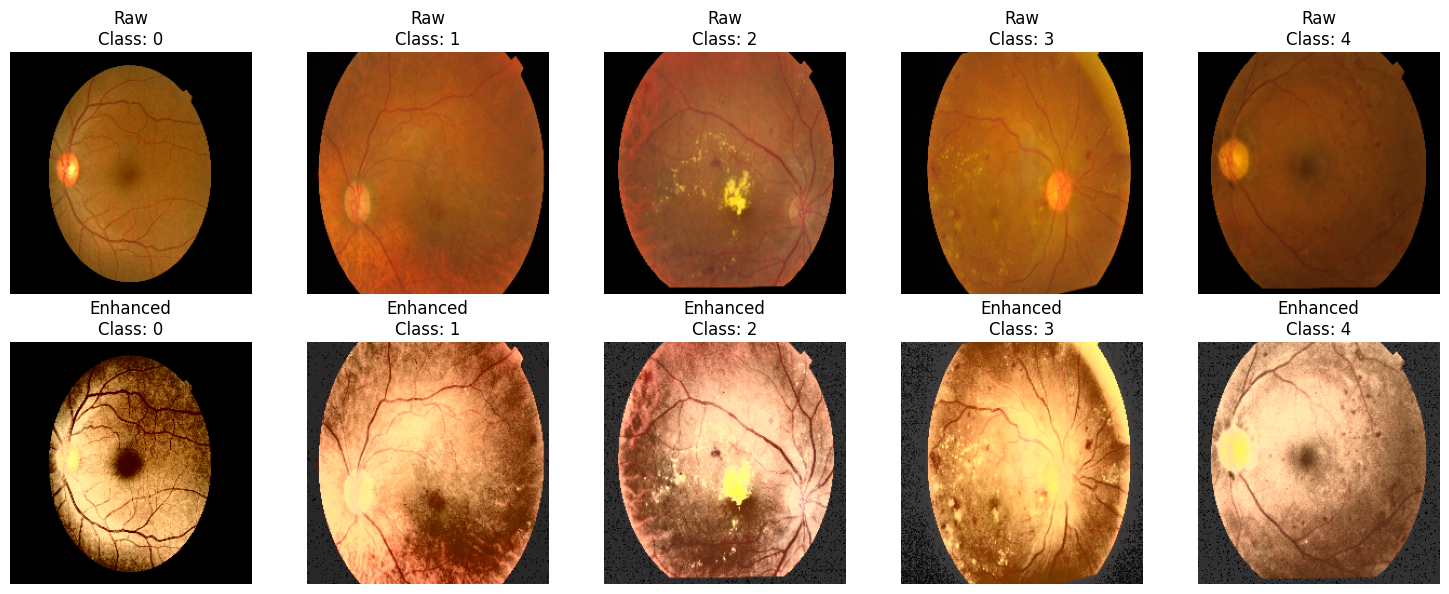

In [30]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random

# Function to load one random image per class
def load_one_image_per_class(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_labels = sorted(os.listdir(directory))  # Ensure classes are sorted for consistency
    for class_idx, class_name in enumerate(class_labels):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            if image_files:  # Ensure the class has at least one image
                random_file = random.choice(image_files)  # Pick one random image
                img_path = os.path.join(class_path, random_file)
                img = cv2.imread(img_path)  # Read image
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, target_size)  # Resize to uniform dimensions
                    images.append(img)
                    labels.append(class_idx)
        # Stop after collecting one image per class if we reach the desired count
        if len(images) == 5:  # Ensure only 5 images are selected
            break
    return np.array(images), np.array(labels)

# Load 5 random images, each from a different class
raw_images, raw_labels = load_one_image_per_class(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH))

# Apply image enhancement to the raw images
enhanced_images = np.array([enhance_image(img) for img in raw_images])

# Visualize raw and enhanced images side-by-side
plt.figure(figsize=(15, 6))

for i in range(5):  # Iterate over the 5 selected images
    # Raw Image
    plt.subplot(2, 5, i + 1)
    plt.imshow(raw_images[i])
    plt.title(f"Raw\nClass: {raw_labels[i]}")
    plt.axis("off")

    # Enhanced Image
    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(enhanced_images[i])
    plt.title(f"Enhanced\nClass: {raw_labels[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Ensure GPU utilization
with tf.device('/GPU:0'):
    def create_inceptionv3_model():
        # Load the InceptionV3 base model
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

        # Make the last few layers trainable for fine-tuning
        for layer in base_model.layers:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

        # Connect inputs to the base model
        x = base_model(inputs, training=False)

        # Add Global Average Pooling
        x = GlobalAveragePooling2D()(x)

        # Add Fully Connected layers
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        # Add output layer with softmax activation
        outputs = Dense(train_generator.num_classes, activation='softmax')(x)

        # Create the model
        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

        return model

# Instantiate the InceptionV3-based model
model = create_inceptionv3_model()

In [ ]:
# Callbacks for early stopping and learning rate adjustment
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Patience reduced from 10 to 5
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
class_names = {0: 'no_DR', 1: 'mild_DR', 2: 'moderate_DR', 3: 'severe_DR', 4: 'proliferative_DR'}
data = []

# Loop through the training directory and collect image names and their labels
for class_id in class_names.keys():
    class_folder = os.path.join(train_dir, str(class_id))
    for filename in os.listdir(class_folder):
        if filename.endswith(".png"):  # or your image extension
            data.append([filename, class_id])

# Create a DataFrame and save it as CSV
labels_df = pd.DataFrame(data, columns=['image', 'level'])
labels_df.to_csv('/kaggle/working/trainLabels.csv', index=False)

labels_csv = r"/kaggle/working/trainLabels.csv"  # Update this path
labels_df = pd.read_csv(labels_csv)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(labels_df['level']),  # Unique class labels
    y=labels_df['level']  # The actual labels
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,  # Subset used
        validation_data=test_generator,
        epochs=50,  # Reduced from 50 to 20 epochs
        steps_per_epoch=len(train_generator) // BATCH_SIZE,
        validation_steps=len(test_generator) // BATCH_SIZE,
        class_weight=class_weights_dict,  # Use class weights
        callbacks=[early_stopping, reduce_lr]
    )

In [ ]:
# Save the trained model
model.save('Updated-Xception-ResNet50-diabetic-retinopathy.h5')

In [ ]:
# Evaluate the model
with tf.device('/GPU:0'):
  test_loss, test_accuracy = model.evaluate(test_generator)

In [ ]:
# Generate predictions
with tf.device('/GPU:0'):
  predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes  # True labels

In [ ]:
# Calculate evaluation metrics
precision = precision_score(y_true, y_pred, average='weighted')
sensitivity = recall_score(y_true, y_pred, average='weighted')
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred, average='weighted')

In [ ]:
# Calculate confusion matrix for specificity
cm = confusion_matrix(y_true, y_pred)
TN = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - cm.diagonal())  # True Negatives
FP = cm.sum(axis=0) - cm.diagonal()  # False Positives

In [ ]:
# Calculate specificity for each class
specificity_list = []
for i in range(cm.shape[0]):  # Loop through each class
    TN = cm.sum() - (cm.sum(axis=0)[i] + cm.sum(axis=1)[i] - cm[i, i])  # True Negatives
    FP = cm.sum(axis=0)[i] - cm[i, i]  # False Positives
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero
    specificity_list.append(specificity)
average_specificity = np.mean(specificity_list)

In [ ]:
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

# Binarize the output for ROC Curve (one-vs-all approach)
y_true_binarized = label_binarize(y_true, classes=np.arange(train_generator.num_classes))
n_classes = y_true_binarized.shape[1]
kappa = cohen_kappa_score(y_true, y_pred)

In [ ]:
# Print metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"F1 Score: {f1:.4f}")
for i, spec in enumerate(specificity_list):
    print(f"Class {i}: Specificity: {spec:.4f}")
print(f"Specificty : {average_specificity :.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

In [ ]:
# Plotting the evaluation metrics
epochs = range(len(history.history['accuracy']))
n_classes = len(specificity_list)
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
plt.figure(figsize=(18, 20))
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ROC Curve
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
